In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from scipy.stats.stats import pearsonr 
from sklearn.decomposition import KernelPCA
import shap
import os
from IPython.display import Image

# Our Journey
## Description Algorithm used for the last Commit

At the dawn of times the preprocessing was based on computing the correlation matrix between the different $\texttt{ROIs}$ (SDS HW03 anyone?) and excluding some unnecessary variables (like `var_1`,`var_2` and `var_3`) and by training a good old `SVM`. 

The first big breaktrough was thanks to the *VEGA* algorithm, found in [this](https://doi.org/10.1101/2021.03.18.435935) paper. The idea is that we need a method to know which features are *really* relevant, above the noise level. This is done by computing the so called *Ricci-Forman curvature* for each edge. This allows, after some steps, to have a sense of which nodes ($\texttt{ROIs}$) in the correlation graph are most important for the cohesion of the network. 
Obtaining in this way a correlation dataframe odf shape (600,1653)

After the selection of this subsets of ROIs, we decide to aggregate samples according their labels(intelligence scores) in order to approximate better the correlation between different ROIs of the brain of the same people.
Reducing the correlation dataframe to shape(99,1653) where 99 is the number of unique 'labels'.

In ordert to reduce even further the amount of features for each sample we use`KernelPCA`.
After PCA the resulting correlation dataframe has a shape of (99,24).

## Other trials
### Approaches in Feature Engineering
* approximate the evolution as a linear dynamic system and then use the state transition matrix as features
* analyze the correlations in the frequency domain
* other (very strange) frequency analysis
* grouped the samples in different ways (mean, median, ...)

### Models
* EVERY POSSIBLE SKLEARN REGRESSION MODEL
* Custom Ensemble methods (mean between SVR and TheilSenRegressor, ...)
* Costant median predictor (shame on us)
* 25 and 75 percentile predictors (more shame on us)
* Regression models augemented using classification methods

In [2]:
train_df=pd.read_csv('./Data/train.csv')
#train_df=pd.read_csv('../input/statistical-learning-sapienza-spring-2021/train.csv')

In [3]:
train_df

,id,y,var1,var2,var3,t1_2001,t2_2001,t3_2001,t4_2001,t5_2001,...,t106_9170,t107_9170,t108_9170,t109_9170,t110_9170,t111_9170,t112_9170,t113_9170,t114_9170,t115_9170
0,1,113.0,19,A,A,-0.140642,-0.388162,-0.574181,-0.583770,-0.376220,...,0.584130,-0.100278,-0.846640,-1.461938,-1.801008,-1.804553,-1.500023,-0.980571,-0.377526,0.168243
1,2,119.0,14,C,A,0.023754,-0.105455,-0.245025,-0.310670,-0.249384,...,-3.024336,-2.480266,-1.118005,0.181451,0.726820,0.401501,-0.356744,-0.913405,-0.854943,-0.193468
2,3,109.0,13,A,A,0.180818,0.135004,0.001879,-0.134548,-0.185928,...,-0.156851,-0.262902,-0.668436,-1.172372,-1.387328,-1.016077,-0.103130,0.935900,1.550512,1.405350
3,4,110.0,18,A,A,-0.234780,-0.094543,0.193084,0.508519,0.668783,...,-1.358540,-0.028478,0.535346,-0.116384,-1.542395,-2.486781,-1.631185,1.481241,6.015514,10.233163
4,5,123.0,32,A,A,-0.130934,-0.360313,-0.547045,-0.603495,-0.508025,...,-0.825535,-0.392556,0.156361,0.567142,0.756362,0.809336,0.844580,0.876423,0.801686,0.524566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,794,110.0,41,A,A,0.059091,0.102927,0.167974,0.235793,0.242588,...,-0.057536,-0.750600,-1.422304,-1.807741,-1.349442,0.350016,2.341956,2.732083,0.976598,-1.039106
596,795,120.0,64,A,A,-0.009643,-0.052258,0.011368,0.121682,0.143449,...,-0.811138,-0.834139,-0.658424,-0.346113,-0.197853,-0.308410,-0.359883,-0.070181,0.296186,0.199696
597,797,96.0,27,A,A,-0.019310,0.082953,0.222301,0.374440,0.447602,...,1.337280,1.089598,1.323202,1.535013,1.084823,0.206892,-0.139006,0.299608,0.321211,-1.356280
598,798,118.0,29,C,A,0.554973,0.227389,-0.422503,-0.088061,0.210051,...,1.632523,2.674116,1.483660,1.520353,-0.672479,-3.975402,-2.972622,0.292423,1.244024,1.499407


# My Brain during the SL HACKATHON

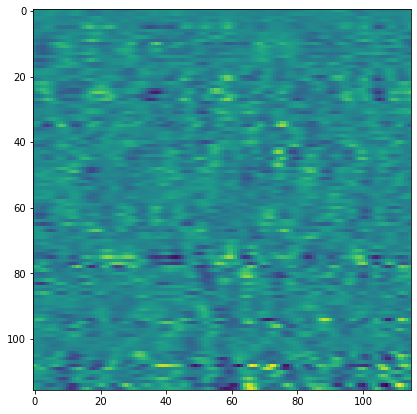

In [4]:
brain = train_df.sample().iloc[:, 5:].values.reshape(116, 115).astype(float)
plt.figure(figsize=(14,7))
plt.imshow(brain);

# Preprocessing

In [5]:
target_values=train_df['y'].unique()

In [6]:
Ric_subjects=[]
epsi=1/116
for index,row in tqdm(train_df.iterrows()):
    subject = np.array(row[5:]).reshape((116, 115)).astype(float)
    corr = np.corrcoef(subject)
    Ric=np.zeros((116,116))
    corr_pos=np.fmax(corr,epsi)
    for i in range(0,116):
        for j in range(i,116):
            val=2-corr_pos[i,j]*(np.sum(1/(np.sqrt(corr_pos[i,j]*corr_pos[i])))+np.sum(1/(np.sqrt(corr_pos[i,j]*corr_pos[j]))))
            Ric[i,j]=val
            Ric[j,i]=val
    Ric_subjects.append(np.mean(Ric,axis=1))

0it [00:00, ?it/s]invalid value encountered in true_divide
invalid value encountered in true_divide
600it [01:15,  7.90it/s]


In [7]:
Ric_subjects_arr=np.array(Ric_subjects)
avg=Ric_subjects_arr.mean(axis=0)
usable_roi=avg>=np.median(avg)
ROI=np.array([f'ROI{i}' for i in range(1,117)])[avg>=np.median(avg)]
columns=[ROI[i]+'-'+ROI[j] for i in range(0,len(ROI)-1) for j in range(i+1,len(ROI))]

In [8]:
m_ricci = []
for v in tqdm(range(len(target_values))):
    corr=[]
    df_y = train_df[train_df['y']==target_values[v]].iloc[:, 5:]
    for i in range(0,116):
        if usable_roi[i]:
            roi_i=df_y.iloc[:,i*115:(i+1)*115]
            for j in range(i+1,116):
                if usable_roi[j]:
                    roi_j=df_y.iloc[:,(j)*115:(j+1)*115]
                    corr.append(pearsonr(roi_i.values.flatten(),roi_j.values.flatten())[0])
    m_ricci.append(corr)
m_ricci = np.array(m_ricci)


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:19<00:00,  5.13it/s]


In [9]:
def get_corr(row,usable_roi,test=False):
    if test:
        brain = np.array(row[4:])
    else:
        brain = np.array(row[5:])
    #brain = brain.reshape((116, 115)).astype(float)
    #corr = np.corrcoef(brain)
    #flat = corr[np.triu_indices(corr.shape[0], 1)]
    corr = []
    for i in range(0,116):
        if usable_roi[i]:
            roi_i=brain[i*115:(i+1)*115]
            for j in range(i+1,116):
                if usable_roi[j]:
                    roi_j=brain[(j)*115:(j+1)*115]
                    corr.append(pearsonr(roi_i.flatten(), roi_j.flatten())[0])
    return corr


In [10]:
corr_df_train=pd.DataFrame(m_ricci,columns=columns).fillna(0)
corr_df_train['y']=target_values

In [11]:
corr_df_train

,ROI1-ROI3,ROI1-ROI4,ROI1-ROI5,ROI1-ROI7,ROI1-ROI8,ROI1-ROI9,ROI1-ROI10,ROI1-ROI11,ROI1-ROI12,ROI1-ROI13,...,ROI110-ROI114,ROI110-ROI115,ROI110-ROI116,ROI113-ROI114,ROI113-ROI115,ROI113-ROI116,ROI114-ROI115,ROI114-ROI116,ROI115-ROI116,y
0,-0.128682,-0.319849,-0.324166,-0.025520,-0.360514,-0.153844,-0.231056,0.406997,-0.019308,0.221273,...,0.317367,0.156731,0.316928,0.598233,0.224943,0.198616,0.627310,0.493860,0.762508,113.0
1,0.215177,-0.324562,0.035001,0.299189,-0.011791,-0.092059,-0.311974,0.525294,0.316897,0.222939,...,0.028930,-0.045873,0.114253,0.542688,0.266197,0.232802,0.610117,0.595988,0.759333,119.0
2,0.368124,0.129039,0.042282,0.320363,0.052695,-0.007191,-0.115823,0.438331,0.243395,0.197927,...,0.266138,-0.046827,0.112721,0.094228,0.005790,0.001743,0.309380,0.356655,0.510192,109.0
3,0.128242,-0.336238,-0.117699,-0.300985,-0.291991,-0.028831,0.049166,0.264095,0.086405,0.101414,...,0.211560,-0.142819,-0.050326,0.520089,0.097454,0.191578,0.496777,0.437103,0.702825,110.0
4,0.126783,-0.036986,-0.107399,0.093512,-0.132265,0.072785,-0.027129,0.206432,0.098717,-0.058600,...,-0.057215,-0.071727,0.428875,0.296669,0.199877,0.037061,0.084179,-0.195883,0.133420,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.351149,-0.038836,0.223067,0.319957,0.030517,0.159190,0.073564,0.437765,-0.078260,0.520290,...,0.073808,0.063758,0.462111,0.502167,-0.034922,0.009250,0.179169,0.015129,0.072416,148.0
95,-0.062977,0.038081,-0.019106,-0.046278,-0.093730,0.160723,0.030468,0.343544,0.294119,0.343351,...,0.162704,-0.049653,0.110388,0.328286,-0.343286,-0.097973,-0.050513,0.062323,0.119114,136.0
96,-0.217757,-0.406463,-0.127794,-0.223247,-0.346684,-0.108791,-0.248721,0.258565,-0.055787,0.025042,...,0.468370,0.172022,-0.092063,-0.278035,-0.062824,0.105871,0.127236,-0.137419,0.384195,79.0
97,0.041617,0.422122,0.218517,0.198131,0.160266,-0.095230,-0.382416,0.069999,0.038906,-0.101761,...,0.257843,0.268758,0.285794,0.243030,0.092524,0.197212,0.302225,0.111809,-0.008902,75.0


# Train

In [12]:
X_train, X_test, y_train, y_test = train_test_split(corr_df_train.drop(columns='y'), corr_df_train['y'], test_size=0.25, random_state=42)

In [13]:
transformer = KernelPCA(n_components=24, kernel='poly',degree=3, fit_inverse_transform=True)
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)
X_train_transformed.shape

(74, 24)

## SVR

In [14]:
params = [{'kernel' : ['poly'],
        'C' : [1,5,10,12,15,20,25],
        'degree' : [2,3,4],
        'coef0' : [0.01,0.02,0.5],
        'gamma' : ['auto','scale'],
        'epsilon':[0.02,0.05,0.1]}]

In [15]:
svr_reg=SVR()
grids = GridSearchCV(svr_reg,params,cv=5,verbose=5,n_jobs=-1)
grids.fit(X_train_transformed,y_train)

Fitting 5 folds for each of 378 candidates, totalling 1890 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [1, 5, 10, 12, 15, 20, 25],
                          'coef0': [0.01, 0.02, 0.5], 'degree': [2, 3, 4],
                          'epsilon': [0.02, 0.05, 0.1],
                          'gamma': ['auto', 'scale'], 'kernel': ['poly']}],
             verbose=5)

In [16]:
grids.best_params_

{'C': 25,
 'coef0': 0.5,
 'degree': 4,
 'epsilon': 0.02,
 'gamma': 'scale',
 'kernel': 'poly'}

In [17]:
y_pred=grids.predict(X_test_transformed)
mean_squared_error(y_test, y_pred,squared=False)

18.93398017902186

## Retrain for predict

In [56]:
transformer_test = KernelPCA(n_components=24, kernel='poly',degree=3, fit_inverse_transform=True, random_state=42)
corr_df_train_transformed = transformer_test.fit_transform(corr_df_train.drop(columns='y'))
svr_reg=SVR(**grids.best_params_)
svr_reg.fit(corr_df_train_transformed,corr_df_train['y'])

SVR(C=25, coef0=0.5, degree=4, epsilon=0.02, kernel='poly')

# Test 

In [38]:
test_df=pd.read_csv('./Data/test.csv')
# test_df=pd.read_csv('../input/statistical-learning-sapienza-spring-2021/test.csv')

In [39]:
corr_test=test_df.progress_apply(lambda row:get_corr(row,usable_roi,test=True),axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:20<00:00,  9.70it/s]


In [40]:
test_final_df=pd.DataFrame(np.array(corr_test.values.tolist())).fillna(0)

In [58]:
test_final_df_transformed=transformer_test.transform(test_final_df)
y_pred_test=svr_reg.predict(test_final_df_transformed)

In [42]:
df_leaderboard=pd.DataFrame({'id':test_df['id'],'target':y_pred_test})

In [43]:
df_leaderboard.to_csv('G14_pca',index=False)

# Interpretability
And now let's see how to interpret a model that does ***NOT*** work.

## Prediction Distribution
Since the first trials we noticed that all the algorithms struggle to catch the outliers and concentrate most of the predictions in the center of the $y$ distribution (that seems to be approximately Normal)

In the plot below you can see the histogram of the predictions (orange) compared with the $y$ estimated density (blue).

That's the reason why we have tried to train models that were able to predict a wide range of values.

The SVR is the best compromise between **"spreadness"** and **loss minimization**.

Other models, although with a smaller RMSE, have their predictions too concentrated around $108$, therefore, they weren't able to generalize on new unseen data.

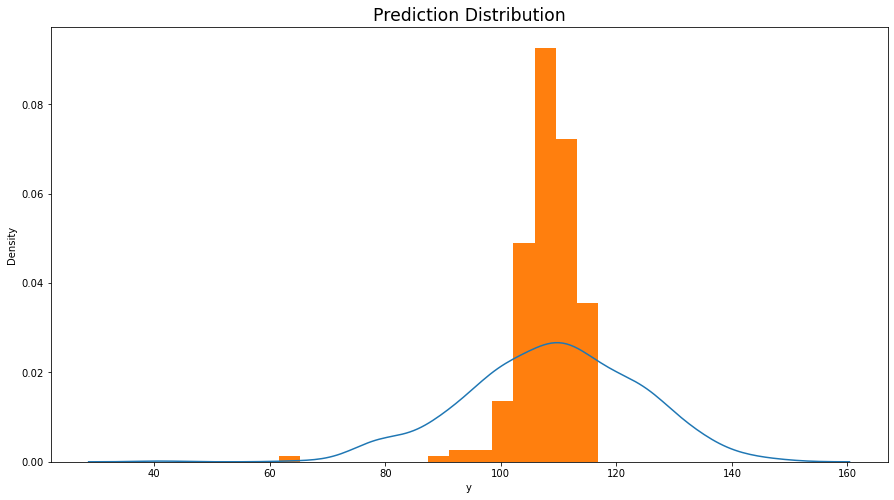

In [44]:
plt.figure(figsize=(15, 8))
plt.title('Prediction Distribution', size='xx-large')
sns.kdeplot(data=train_df['y'])
plt.hist(y_pred_test, density=True, bins=15)
plt.show()

## Residual plot

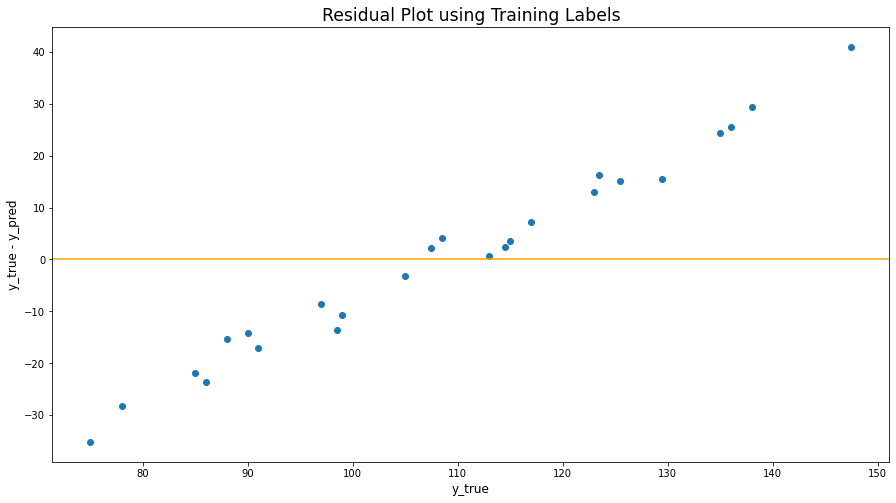

In [45]:
plt.figure(figsize=(15, 8))
plt.title('Residual Plot using Training Labels', size='xx-large')
plt.scatter(y_test, (y_test-y_pred))
plt.axhline(y=0, c='orange')
plt.xlabel('y_true', size=12)
plt.ylabel('y_true - y_pred', size=12)
plt.show()

## Prediction Plot
Look at how little `y_pred` is spread with respect to `y_true`

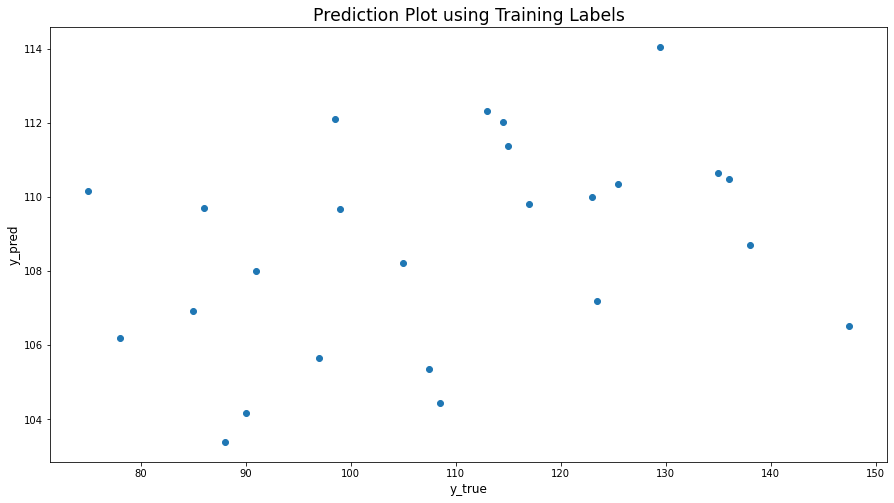

In [46]:
plt.figure(figsize=(15, 8))
plt.title('Prediction Plot using Training Labels', size='xx-large')
plt.scatter(y_test, y_pred)
plt.xlabel('y_true', size=12)
plt.ylabel('y_pred', size=12)
plt.show()

# SHAP


In [47]:
X_test_transformed = pd.DataFrame(X_test_transformed, columns=[f'Feature_{i+1}' for i in range(24)])

  0%|          | 0/25 [00:00<?, ?it/s]

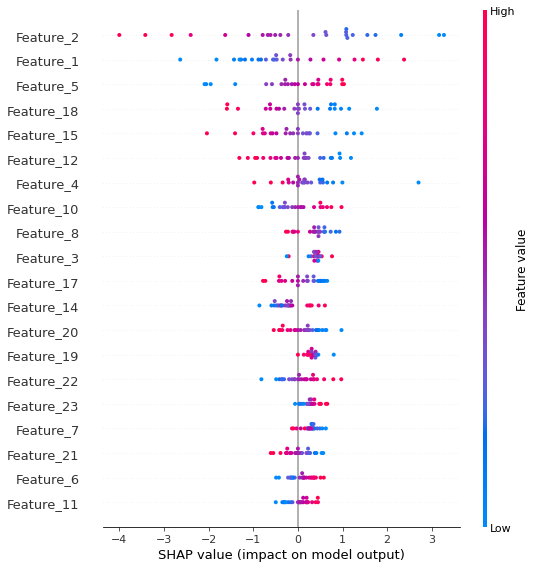

In [48]:
explainer = shap.KernelExplainer(grids.predict, X_train_transformed)
plt.figure(figsize=(16, 10))
shap_values = explainer.shap_values(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed)

The plot above tells us how the variables affect the prediction in the model (according to the `shap` framework). A positive `shap value` means that a particular variable influenced the prediction towards greater values, and a negative `shap value` vice versa. This is accompained by the intensity of the feature value.

## Back in the Original Space
Using the plot above we find the 5 most important features which are:
* Feature_2
* Feature_1
* Feature_5
* Feature_18
* Feature_15

We decided to inverse trasform them to the original space through the (inverse) KernelPCA and we fund that they are pretty close to each other: their cosine similarity is around $\sim0.98$

In [64]:
most_important_features = [1,0,4,17,14]
vec = np.zeros_like(X_test_transformed[:len(most_important_features)])
for row, col in enumerate(most_important_features):
    vec[row, col] = 1
main_directions = transformer_test.inverse_transform(vec)
for i in range(len(most_important_features)):
    for j in range(i+1, len(most_important_features)):
        print(f'Cosine similarity between dir-{i} and dir-{ j}: {np.dot(main_directions[i], main_directions[j]) / np.linalg.norm(main_directions[[i, j]], axis=1).prod()}')

Cosine similarity between dir-0 and dir-1: 0.9634255256873391
Cosine similarity between dir-0 and dir-2: 0.9766379783659115
Cosine similarity between dir-0 and dir-3: 0.9813088204123265
Cosine similarity between dir-0 and dir-4: 0.9812670433694954
Cosine similarity between dir-1 and dir-2: 0.9706912975283011
Cosine similarity between dir-1 and dir-3: 0.9747709328828928
Cosine similarity between dir-1 and dir-4: 0.9751009784281786
Cosine similarity between dir-2 and dir-3: 0.9866514208382072
Cosine similarity between dir-2 and dir-4: 0.9857221395530394
Cosine similarity between dir-3 and dir-4: 0.9918327200766739


In [50]:
pd.DataFrame(main_directions, columns=columns)

,ROI1-ROI3,ROI1-ROI4,ROI1-ROI5,ROI1-ROI7,ROI1-ROI8,ROI1-ROI9,ROI1-ROI10,ROI1-ROI11,ROI1-ROI12,ROI1-ROI13,...,ROI110-ROI113,ROI110-ROI114,ROI110-ROI115,ROI110-ROI116,ROI113-ROI114,ROI113-ROI115,ROI113-ROI116,ROI114-ROI115,ROI114-ROI116,ROI115-ROI116
0,0.013802,-0.095798,-0.040948,0.087262,-0.123868,-0.054549,-0.121707,0.327648,0.104790,0.145985,...,0.128230,0.127834,0.096391,0.120948,0.362360,0.196683,0.172029,0.413364,0.275123,0.453379
1,-0.001578,-0.158426,-0.055632,0.089904,-0.161901,-0.061936,-0.135105,0.342849,0.076665,0.156337,...,0.178395,0.192304,0.118794,0.133616,0.372369,0.203212,0.191122,0.409711,0.324786,0.515076
2,0.001670,-0.130677,-0.057406,0.058269,-0.165108,-0.064298,-0.137820,0.307669,0.061138,0.128356,...,0.139416,0.138013,0.073867,0.096733,0.335610,0.158973,0.146020,0.359732,0.256046,0.457492
3,0.019365,-0.117958,-0.024182,0.084954,-0.145204,-0.033454,-0.127752,0.328091,0.078194,0.167243,...,0.132752,0.103521,0.088436,0.104442,0.317216,0.169578,0.146206,0.372763,0.243167,0.438809
4,0.002647,-0.125460,-0.036923,0.058276,-0.157317,-0.045256,-0.132172,0.309098,0.076910,0.141611,...,0.121434,0.114292,0.071826,0.098019,0.299560,0.150766,0.145386,0.372496,0.257640,0.437705


Then we perform the same analysis over all the features of the transformed space and we find out that, even if `shap` tells us that some features are more important than others, they have a great degree of correlation between them. 
Dispite the transformation performed by the KernelPCA the resulting freature appear still correlated.

In [51]:
transformed_features = range(24)
vec = np.zeros_like(X_test_transformed[:len(transformed_features)])
for row, col in enumerate(transformed_features):
    vec[row, col] = 1
main_directions = transformer_test.inverse_transform(vec)

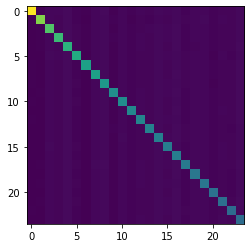

In [52]:
plt.imshow(transformer_test.transform(main_directions))

In [53]:
pd.DataFrame(main_directions, columns=columns)
#X_test.shape

,ROI1-ROI3,ROI1-ROI4,ROI1-ROI5,ROI1-ROI7,ROI1-ROI8,ROI1-ROI9,ROI1-ROI10,ROI1-ROI11,ROI1-ROI12,ROI1-ROI13,...,ROI110-ROI113,ROI110-ROI114,ROI110-ROI115,ROI110-ROI116,ROI113-ROI114,ROI113-ROI115,ROI113-ROI116,ROI114-ROI115,ROI114-ROI116,ROI115-ROI116
0,-0.001578,-0.158426,-0.055632,0.089904,-0.161901,-0.061936,-0.135105,0.342849,0.076665,0.156337,...,0.178395,0.192304,0.118794,0.133616,0.372369,0.203212,0.191122,0.409711,0.324786,0.515076
1,0.013802,-0.095798,-0.040948,0.087262,-0.123868,-0.054549,-0.121707,0.327648,0.104790,0.145985,...,0.128230,0.127834,0.096391,0.120948,0.362360,0.196683,0.172029,0.413364,0.275123,0.453379
2,0.017416,-0.062251,-0.034501,0.107840,-0.107344,-0.054860,-0.111603,0.292815,0.088906,0.134633,...,0.098662,0.109967,0.078579,0.096888,0.320141,0.153655,0.129375,0.358518,0.222519,0.423834
3,0.039259,-0.094557,-0.008359,0.077488,-0.154323,-0.029586,-0.118288,0.292858,0.042803,0.137733,...,0.132286,0.099498,0.062603,0.117750,0.361142,0.165283,0.157193,0.388325,0.268627,0.459281
4,0.001670,-0.130677,-0.057406,0.058269,-0.165108,-0.064298,-0.137820,0.307669,0.061138,0.128356,...,0.139416,0.138013,0.073867,0.096733,0.335610,0.158973,0.146020,0.359732,0.256046,0.457492
5,0.029214,-0.134168,-0.026390,0.065086,-0.149982,-0.025185,-0.116213,0.332874,0.077793,0.175227,...,0.149957,0.148479,0.114097,0.129032,0.319974,0.140744,0.152890,0.344281,0.237338,0.416176
6,0.002637,-0.155143,-0.034248,0.056598,-0.187214,-0.040771,-0.122437,0.328768,0.052916,0.170248,...,0.115195,0.130226,0.057346,0.101708,0.327236,0.169179,0.149748,0.376032,0.240491,0.452474
7,-0.011541,-0.132314,-0.039270,0.067876,-0.145457,-0.039331,-0.109026,0.320204,0.108659,0.181195,...,0.124395,0.115833,0.077680,0.103643,0.311811,0.147681,0.125280,0.368755,0.221665,0.411720
8,-0.014928,-0.130113,-0.050843,0.054189,-0.160003,-0.063676,-0.119615,0.288689,0.053523,0.126119,...,0.126241,0.116723,0.058666,0.099125,0.324977,0.176556,0.156612,0.381678,0.254445,0.436102
9,0.017052,-0.127258,-0.041875,0.072515,-0.167224,-0.044033,-0.138482,0.320038,0.070656,0.174757,...,0.139659,0.115932,0.058230,0.099294,0.341856,0.191682,0.169638,0.375009,0.275887,0.458169


<Figure size 432x288 with 0 Axes>

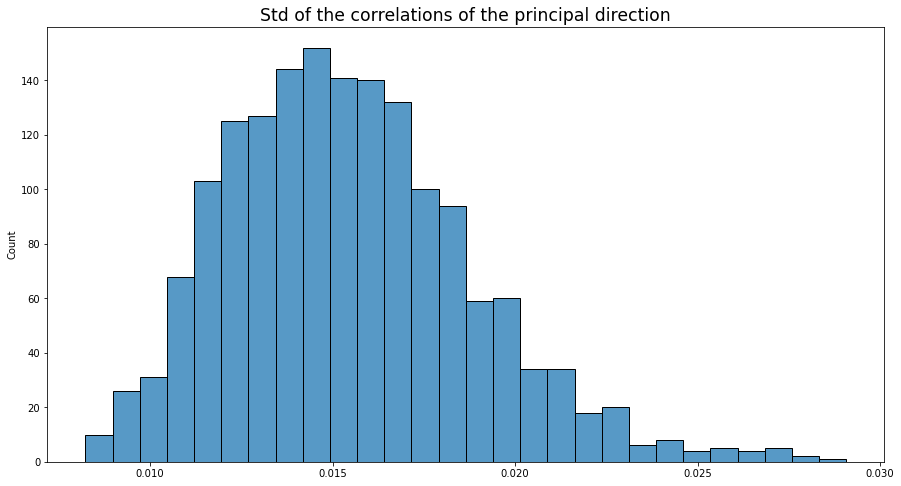

In [35]:
plt.figure()
plt.figure(figsize=(15, 8))
plt.title('Std of the correlations of the principal direction', size='xx-large')
sns.histplot(pd.DataFrame(main_directions, columns=columns).std())
# plt.ylabel('')
plt.show()

<AxesSubplot:title={'center':'Std of the correlations of the principal direction'}>

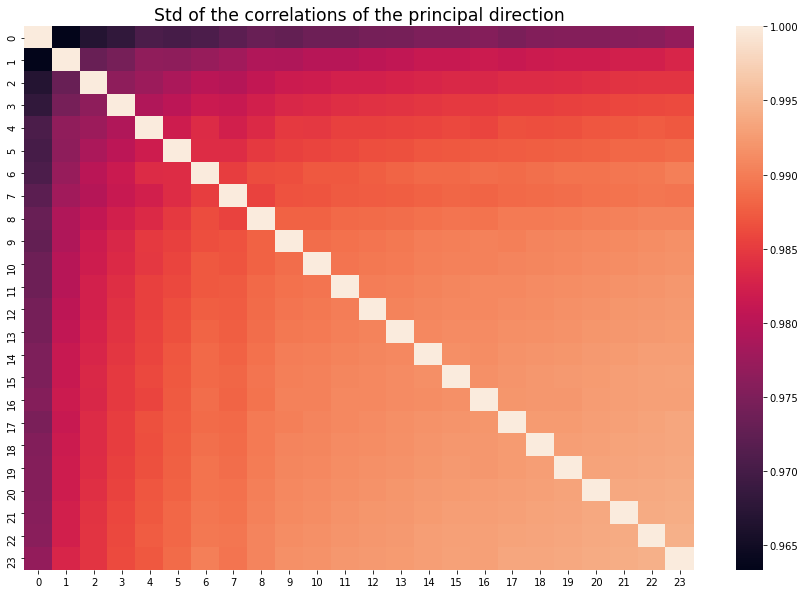

In [36]:
plt.figure(figsize=(15, 10))
plt.title('Std of the correlations of the principal direction', size='xx-large')
sns.heatmap(data=np.corrcoef(main_directions))

These two plots support our observations:
* the std of the correlations between the ROIs of the approximated principal components are small
* the correlation of the brain region interactions are close to 1

The first two components, that should be *much different from one another* (because they are the ones that bring more information according to `PCA`), still have a correlation $>0.97$!!!

# And then...
## the final question
### we are all waiting for...
<img src="./Brutti_question.jpeg">
<img src="./Our_answer.jpeg">

In [ ]:
Image(filename="../input/important-photo/Brutti_question.jpeg", width=800, height=800)

In [ ]:
Image(filename="../input/important-photo/Our_answer.jpeg", width=800, height=800)